# Analysis of "visual clutter" dataset

### Trajectories collected in single object forest with 2 different fog settings

### Assumes use of FlyOver version 1.0.5 of higher

In [30]:
import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk, getcwd
from os.path import isfile, sep
from sys import path, exit
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# Set path to analysis code directory
codeDir = sep.join(getcwd().split(sep)[:-2])
path.insert(1, codeDir)

from flyVR.utilities.loadObjectCoords import loadObjectCoordIdentities
from flyVR.flyVRAnalysis.flyVR_oneTrialBasicAnalysis import singleVRTrialAnalysis

from trajectoryAnalysis.downsample import donwsampleFOData
from trajectoryAnalysis.periodicWorldAnalysis import collapseToMiniArena
from trajectoryAnalysis.circularStatsOnTrajectories import circmeanvec, fractional_polar_axes, RayleighTest
from trajectoryAnalysis.trajectoryDerivedParams import relationToObject, cartesian2polar, polarCurvature

from plottingUtilities.basicPlotting import makeNestedPlotDirectory, myAxisTheme,_myAccentList
from plottingUtilities.objectInteractionPlots import residencyWithHistograms, plotResidencyInMiniarena,\
                            oneDimResidencyWithVar_df, plotWalkingVelocityDistr
from plottingUtilities.plotsWithDataframe import oneDimResidency_df


# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/visualClutter/'

In [31]:
 root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
root.update()
root.destroy()
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)

rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
                               'instead of loading previously saved data? (y, n)\n')


 Analysing the following folders:

['f01A', 'f01B', 'f02A', 'f02B', 'f03A', 'f03B', 'f04A', 'f04B', 'f05A', 'f05B', 'f06A', 'f06B']
Would you like to (re-)run the basic analysis on each file 
instead of loading previously saved data? (y, n)
n


In [32]:
genotype = dataDir.split(sep)[-4]
sex = dataDir.split(sep)[-3]
print('genotype: {0}; sex:{1}'.format(genotype, sex))

genotype: WTB; sex:female


In [33]:
expDirs=expDirs[:]
print(expDirs)

['f01A', 'f01B', 'f02A', 'f02B', 'f03A', 'f03B', 'f04A', 'f04B', 'f05A', 'f05B', 'f06A', 'f06B']


In [34]:
# Uncomment, if you want to select a specific subset of flies (e.g. good learners..)
#from operator import itemgetter
#my_indices = [7,8,9,10]#[0,2,4,6,7,8,9,10,11,12]
#expDirs = itemgetter(*my_indices)(expDirs)

selectionTag = ''  # chose small string, to specify dataset (e.g. top5 flies)

In [35]:
%matplotlib inline 

### Define structure of trials in terms of closed-loop optogenetic stimulation and presence of landmark cues

In [36]:
gridSize = 60.0

coneColor = 'mediumseagreen'
groupNames = ['A', 'B']
trialtypes = ['denseFog', 'lightFog']
trialOrder={
    'A': ('denseFog', 'lightFog'),
    'B': ('lightFog', 'denseFog')
}

fogcols = {
    'denseFog': 'grey',
    'lightFog':'slateblue'
}

visitRad = 15

vTransTH = 2 #mm/s

coneCoords = [0,0]

### Compose mutli-fly data into dataframe

In [37]:
# generate fly color map
numFlies = len(expDirs)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)

mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

In [38]:
keylist = ['headingAngle','rotVelo','time','transVelo',
           'xPos','xPosInMiniarena','yPos','yPosInMiniarena','rEvents']

keylistLong = ['flyID','trial','group','trialtype','reinforcement','moving'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)


In [39]:
# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:
        
        flyID = currExpDir
        trial = fileToAnalyse.split('_')[-2][-1]
        
        if rerunbasicanalysis == 'y':
            returnVal = singleVRTrialAnalysis(expDir + fileToAnalyse)
            print('Ran analysis, now loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
        else:
            print('Loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]

        # Split into visible object trials and invisible object trials
        group = fileToAnalyse.split('_')[-4]
        trialtype = trialOrder[group][int(trial)-1]
        rZones = 'off'
        
        vTrans = np.copy(FODatLoad['transVelo'])
        moving = vTrans >= vTransTH

        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'group', group)
        FODatLoad_df.insert(3, 'trialtype', trialtype)
        FODatLoad_df.insert(4, 'reinforcement', rZones)
        FODatLoad_df.insert(5, 'moving', moving)
        
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/visualClutter/WTB/female/rawData/f01A/

 Analysing the following log files:

['singleObjectForest_visualClutter_fog120-360_WTB_f01_A_7-8d_t2_180612165758.txt', 'singleObjectForest_visualClutter_fog60-75_WTB_f01_A_7-8d_t1_180612164529.txt']
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/visualClutter/WTB/female/rawData/f01B/

 Analysing the following log files:

['singleObjectForest_visualClutter_fog120-360_WTB_f01_B_8-9d_t1_180611163921.txt', 'singleObjectForest_visualClutter_fog60-75_WTB_f01_B_8-9d_t2_180611165032.txt']
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/visualClutter/WTB/female/rawData/f02A/

 Analysing the following log files:

['singleObjectForest_visualClutter_fog120-360_WTB_f02_A_7-8d

In [40]:
FOAllFlies_df = FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')
FOAllFlies_df['reinforcement'] = FOAllFlies_df['reinforcement'].astype('category')

FOAllFlies_df.head()

,flyID,trial,group,trialtype,reinforcement,moving,headingAngle,rotVelo,time,transVelo,xPos,xPosInMiniarena,yPos,yPosInMiniarena,rEvents
0,f01A,2,A,lightFog,off,1.0,-0.000004,0.000000,0.000000,13.047947,60.650400,NaN,34.971600,NaN,NaN
1,f01A,2,A,lightFog,off,1.0,-0.000004,-0.177398,0.050005,9.760271,61.297613,NaN,35.054186,NaN,NaN
2,f01A,2,A,lightFog,off,1.0,-0.008875,-0.088737,0.100010,14.381102,61.756125,NaN,35.221431,NaN,NaN
3,f01A,2,A,lightFog,off,1.0,-0.013312,0.000000,0.150015,12.437406,62.463646,NaN,35.350104,NaN,NaN
4,f01A,2,A,lightFog,off,1.0,-0.013312,0.621158,0.200020,7.991544,63.008853,NaN,35.649349,NaN,NaN


In [41]:
flyIDallarray = np.asarray(FOAllFlies_df['flyID'])
flyIDs = sorted(list(set(flyIDallarray.tolist())))

In [42]:
flyIDsStripped = sorted(list(set([flyID[:-1] for flyID in flyIDs ])))
numFliesGroup = len(flyIDsStripped)
flyIDsStripped

['f01', 'f02', 'f03', 'f04', 'f05', 'f06']

In [43]:
keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')
keyind_EV = keylistLong.index('rEvents')

### Trajectory plots of all flies

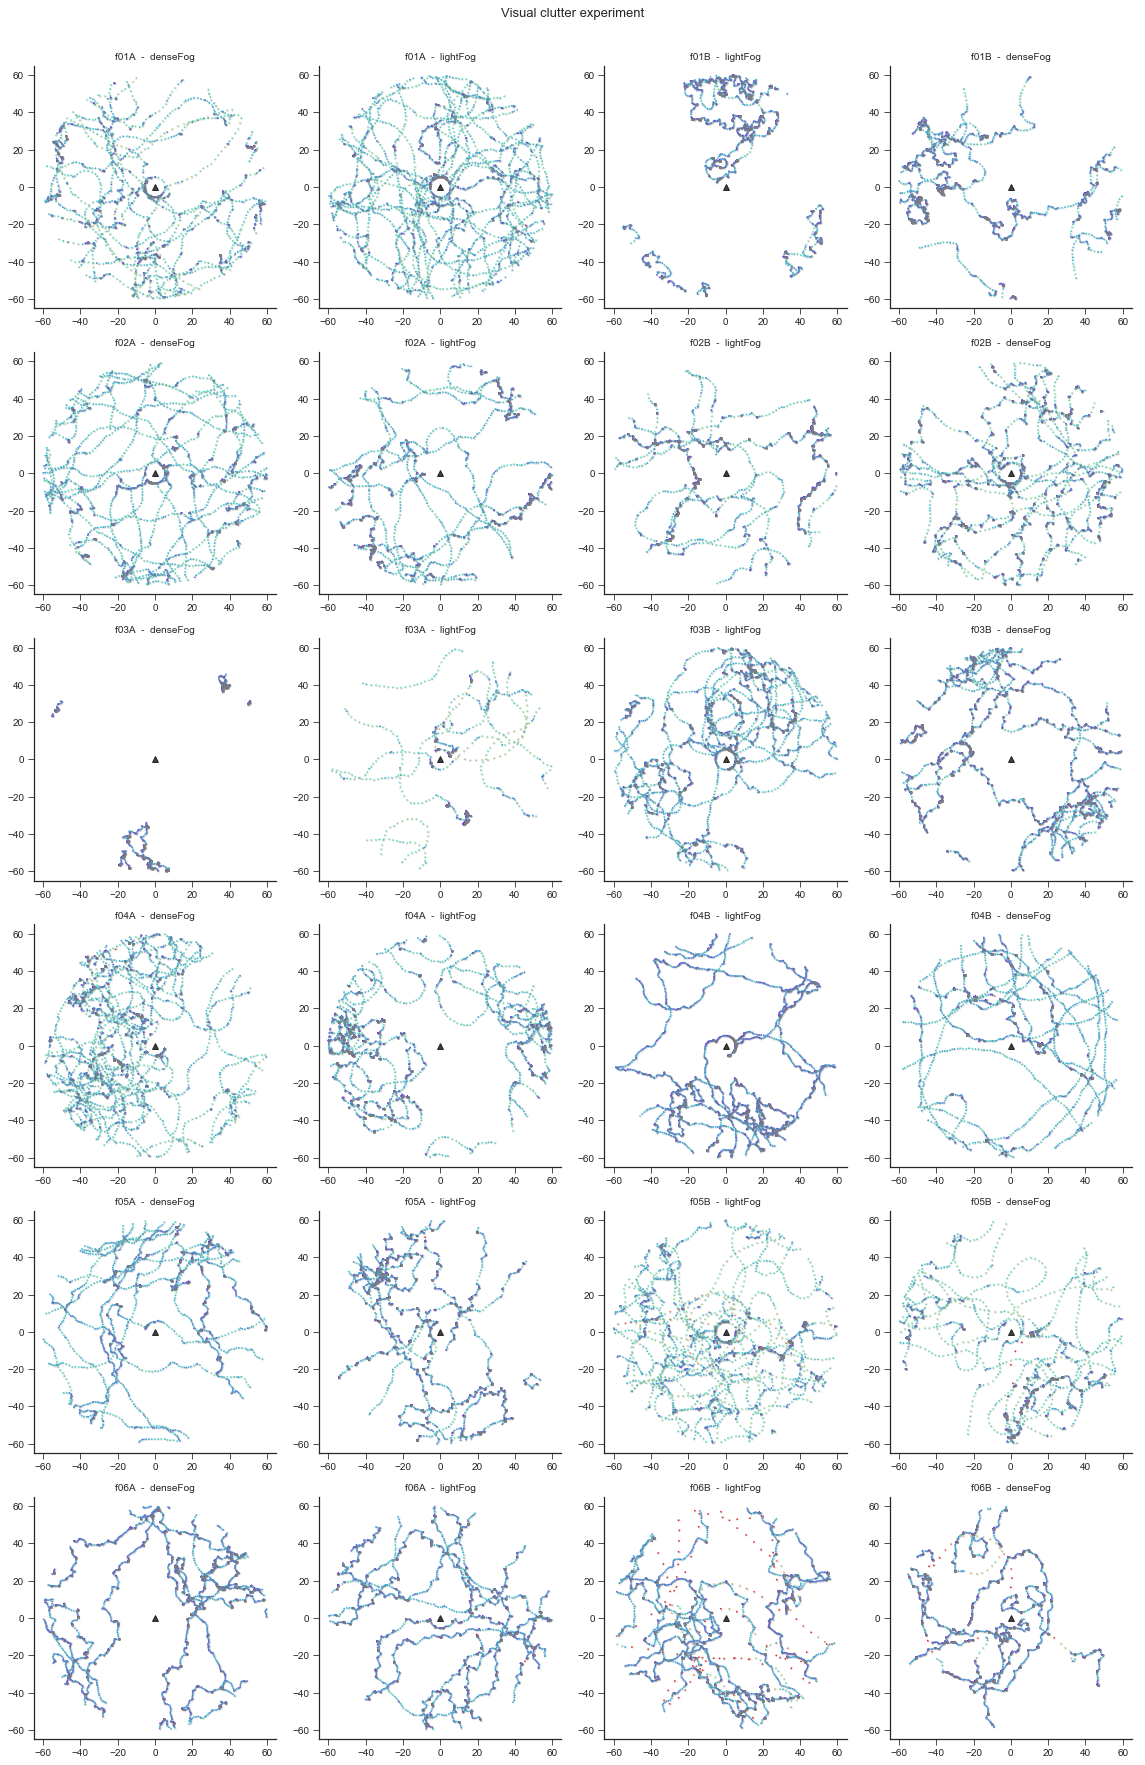

In [44]:
ncols = numFliesGroup

multiflyTracePlot, axs = plt.subplots(ncols,4,figsize=(4*4,4*ncols))
figtitle = multiflyTracePlot.suptitle('Visual clutter experiment' ,fontsize=13,y=1.02)

for group in groupNames:
    for fly in range(numFliesGroup):
        for t, ttype in enumerate(trialtypes):
            
            sbplt = axs[fly,int(group=='A')*t +  int(group=='B')*abs(1-t+2)]

            flyID = flyIDsStripped[fly]+group
            querystring = '(flyID =="'+flyID+'") & (trialtype=="'+ttype+'")'

            perFlyX = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
            perFlyY = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
            perFlyvT = FOAllFlies_df.query(querystring)['transVelo'].values.squeeze()

            selectPts = range(0,len(perFlyX),3)
            sbplt.plot(perFlyX[selectPts],perFlyY[selectPts],'.',markersize=3,color='grey',alpha=0.2)
            sbplt.scatter(perFlyX[selectPts],perFlyY[selectPts],s=3, c=perFlyvT[selectPts], cmap='rainbow',
                                            vmin=-1, vmax=35, edgecolor='none',alpha=0.9)

            sbplt.plot(coneCoords[0], coneCoords[1], marker='^', markersize=6, alpha=0.75, color='black')

            myAxisTheme(sbplt)
            sbplt.set_title(flyID+'  -  '+ttype,fontsize=10)
            sbplt.set_aspect('equal')
            sbplt.set_xlim(-gridSize-5, gridSize + 5)
            sbplt.set_ylim(-gridSize-5, gridSize + 5)

    multiflyTracePlot.tight_layout()

multiflyTracePlot.savefig(analysisDir +'tracePlotMA/'+ genotype +'_'+flyIDs[0][0]
                +'_traceVeloColored_n'+ str(numFlies) +selectionTag+'.pdf', format='pdf', 
                 bbox_extra_artists=(figtitle,), bbox_inches='tight')

## Velocity distribution

In [45]:
histRangeVT = (vTransTH, 30)
histRangeVR = (-5,5)
numBins = 30

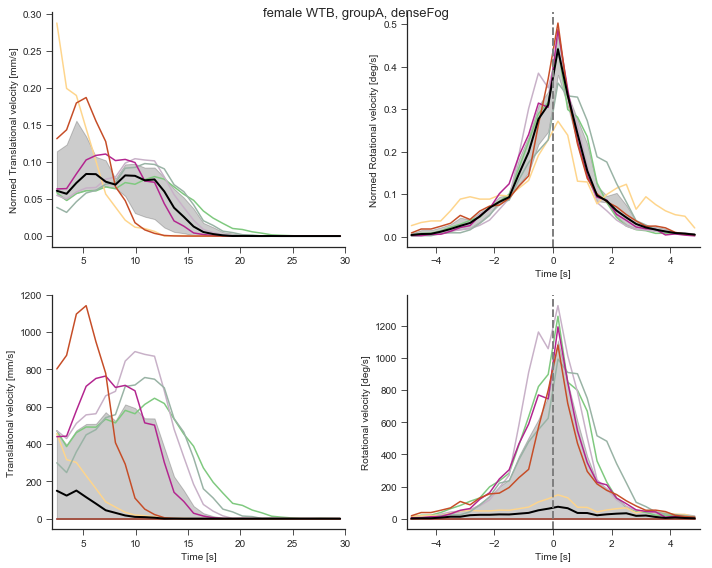

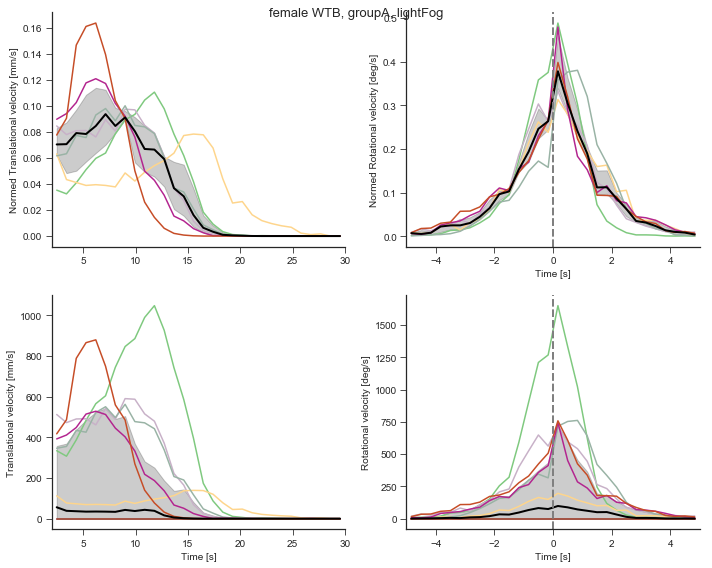

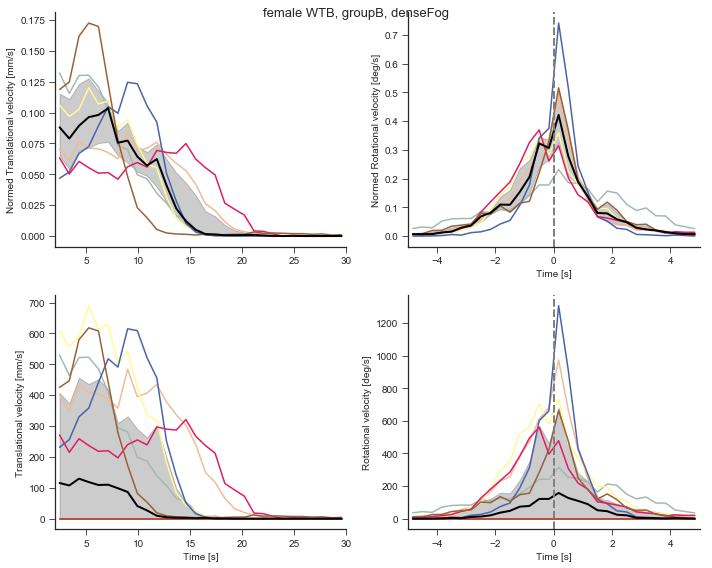

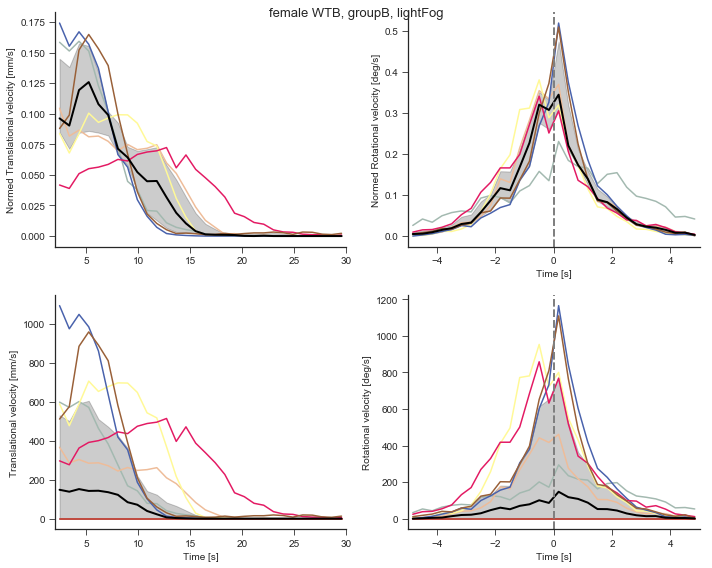

In [46]:
for group in groupNames:
    for t, ttype in enumerate(trialtypes):
        
        titleString =  sex + ' ' + genotype + ', group' + group + ', ' + ttype
        group_df = FOAllFlies_df.query('(group =="'+group+'") & (trialtype=="'+ttype+'")')
        walkingFig = plotWalkingVelocityDistr(group_df, flyIDs, keyind_mov, keyind_vT, keyind_vR, flyCMap,
                                     histRangeVT, histRangeVR,numBins, numFlies)
        walkingFig.suptitle(titleString, fontsize=13)
        walkingFig.tight_layout()

        walkingFig.savefig(analysisDir + sep + 'velocityTraces' + sep + genotype + '_' + sex + '_walingVelocities'+\
                           '_group' + group + '_' +ttype+'_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

#### Velocity differences between groups

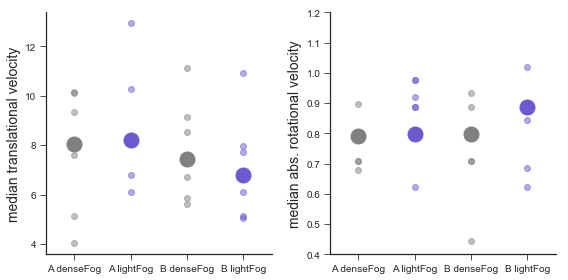

In [47]:
fig, axs = plt.subplots(1,2, figsize=(8,4))

xlab = []
for g, group in enumerate(groupNames):
    for t, ttype in enumerate(trialtypes):
        pos = g*2 + t + 1
        xlab.append(group+' '+ttype)
        
        for fly in flyIDsStripped:
            fly_df = FOAllFlies_df.query('(flyID =="'+fly+group+'") & (trialtype=="'+ttype+'") & (moving > 0)')
            
            axs[0].plot(pos, np.nanmedian(fly_df['transVelo'].values),'o', color=fogcols[ttype], alpha=0.5)
            axs[1].plot(pos, np.nanmedian(abs(fly_df['rotVelo'].values)),'o', color=fogcols[ttype],alpha=0.5)
            
        group_df = FOAllFlies_df.query('(group =="'+group+'") & (trialtype=="'+ttype+'") & (moving > 0)')
            
        axs[0].plot(pos, np.nanmedian(group_df['transVelo'].values),'o', color=fogcols[ttype], markersize=15, alpha=1)
        axs[1].plot(pos, np.nanmedian(abs(group_df['rotVelo'].values)),'o', color=fogcols[ttype], markersize=15, alpha=1)
        
        
axs[0].set_ylabel('median translational velocity', fontsize=14)
axs[1].set_ylabel('median abs. rotational velocity', fontsize=14)
axs[1].set_ylim(0.4, 1.2)
for ax in axs:
    myAxisTheme(ax)
    plt.sca(ax)
    plt.xticks(np.arange(1,5), xlab)
    ax.set_xlim(0.5, 4.5)
fig.tight_layout()

fig.savefig(analysisDir + sep + 'velocityTraces' + sep + genotype + '_' + sex +
                '_velocityGroupComparison_median_n'+str(numFlies)+'.pdf', format = 'pdf')

## Residency

### 2D (cartesian) residency

Plot directory already exists


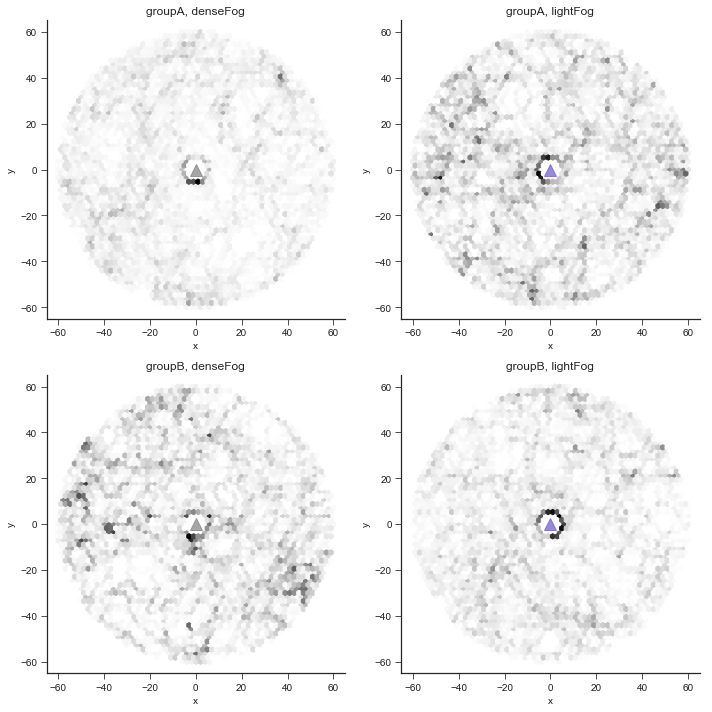

In [48]:
# plot parameter
numBins = 60

hexplotfig, axs = plt.subplots(len(groupNames), len(trialtypes), figsize=(10,10))
for g, group in enumerate(groupNames):
    for t, ttype in enumerate(trialtypes):
        querystring = '(group =="'+group+'") & (trialtype=="'+ttype+'") & (moving > 0)'
        xPosMA = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        yPosMA = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        
        axs[g,t].hexbin(xPosMA, yPosMA, gridsize=numBins, cmap='Greys')
        axs[g,t].set_xlabel('x'); axs[g,t].set_ylabel('y')

        axs[g,t].plot(coneCoords[0],coneCoords[1], marker='^', markersize=12, alpha=0.7, color=fogcols[ttype])            
        axs[g,t].set_title('group'+group+', '+ttype)
        axs[g,t].set_xlim(-gridSize-5,gridSize+5)
        axs[g,t].set_ylim(-gridSize-5,gridSize+5)
        axs[g,t].set_aspect('equal')
        myAxisTheme(axs[g,t])
        
hexplotfig.tight_layout()
try:
    mkdir(analysisDir + 'residencyPlots/')
except:
    print('Plot directory already exists')
hexplotfig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_residencyMA_n'+str(numFlies) +selectionTag+'.pdf', format='pdf')

### 1D radial residency close around objects

In [49]:
resdf_keylist_short = ['flyID','trial','trialtype','reinforcement','moving','time']
resdf_keylist = resdf_keylist_short + ['dist2LM']
residency_df = pd.DataFrame(data=np.zeros((0,len(resdf_keylist))), columns=resdf_keylist)

for g, group in enumerate(groupNames):
    for t, ttype in enumerate(trialtypes):
        for fly in range(len(flyIDsStripped)):
            
            querystring = '(flyID == "'+flyIDsStripped[fly]+group+'") & (trialtype=="'+ttype+'") & (moving > 0)'
            xPosTrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
            yPosTrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
            timeTrial = FOAllFlies_df.query(querystring)['time'].values.squeeze()
            
            # compute distance to landmark
            dist2LM = np.hypot((xPosTrial-coneCoords[0]),(yPosTrial-coneCoords[1]))

            tmpdf = FOAllFlies_df.query(querystring)[resdf_keylist_short]
            tmpdf.insert(1,'dist2LM', dist2LM)

            residency_df = residency_df.append(tmpdf)

residency_df = residency_df[resdf_keylist]

In [50]:
def oneDimResidencyWithVar_singleCondition(radResPlt, resdf, flyIDs, resCol, trialName, LMcoord, movementFilter, group,
                              numBins, histRange, lineAlpha, plotLog, varstyle, fill):

    # normalisation factor for cirle area rings
    areaNormA = np.square(np.linspace(histRange[0], histRange[1], numBins))*np.pi
    areaNorm = areaNormA[1:]-areaNormA[:-1]

    numFlies = len(flyIDs)
    
    trialRadRes = np.zeros((numFlies, numBins-1))
    for fly in range(numFlies):
        querystring = '('+movementFilter+')&(flyID=="'+flyIDs[fly]+group+'")'

        xPosTrial = resdf.query(querystring)['xPosInMiniarena'].values.squeeze()
        yPosTrial = resdf.query(querystring)['yPosInMiniarena'].values.squeeze()
        objDist = np.hypot((xPosTrial-LMcoord[0]),(yPosTrial-LMcoord[1]))
        
        radresidency, edges = np.histogram(objDist[~np.isnan(objDist)], bins=np.linspace(histRange[0], histRange[1], numBins).astype(int))
        trialRadRes[fly, :] = radresidency/areaNorm

        jitterRange = 0.2*np.diff(histRange)/numBins

    if plotLog:
        if varstyle == 'std':
            toplot = np.log(np.nanmean(trialRadRes,0))
            var1 = np.log(np.nanmean(trialRadRes,0) + np.nanstd(trialRadRes,0))
            var2 = np.log(np.nanmean(trialRadRes,0) - np.nanstd(trialRadRes,0))
        elif varstyle == 'iqr':
            toplot = np.log(np.nanmedian(trialRadRes,0))
            [var1, var2] = np.log(np.nanpercentile(trialRadRes,[25,75],axis=0))
        else:
            toplot = np.log(np.nanmean(trialRadRes,0))
    else:
        if varstyle == 'std':
            toplot = np.nanmean(trialRadRes,0)
            var1 = toplot + np.nanstd(trialRadRes,0)
            var2 = toplot - np.nanstd(trialRadRes,0)
        elif varstyle == 'iqr':
            toplot = np.nanmedian(trialRadRes,0)
            [var1, var2] = np.nanpercentile(trialRadRes,[25,75],axis=0)
        else:
            toplot = np.nanmean(trialRadRes,0)

    lhand, = radResPlt.plot(edges[:-1]+np.diff(edges)/2.0, toplot, color=resCol,alpha=lineAlpha,linewidth=3,
                            label=trialName + ' ('+group+')')
    radResPlt.plot(edges[:-1]+np.diff(edges)/2.0, var1,color=resCol, alpha=lineAlpha,linewidth=1, label='')
    radResPlt.plot(edges[:-1]+np.diff(edges)/2.0, var2,color=resCol, alpha=lineAlpha,linewidth=1, label='')
    if fill:
        radResPlt.fill_between(edges[:-1]+np.diff(edges)/2.0, var1, var2, color=resCol, alpha=0.2, label='')

    radResPlt.set_xlabel('object distance [mm]', fontsize=12)
    if plotLog:
        radResPlt.set_ylabel('log(area corrected residency)', fontsize=12)
    else:
        radResPlt.set_ylabel('area corrected residency', fontsize=12)

    return radResPlt


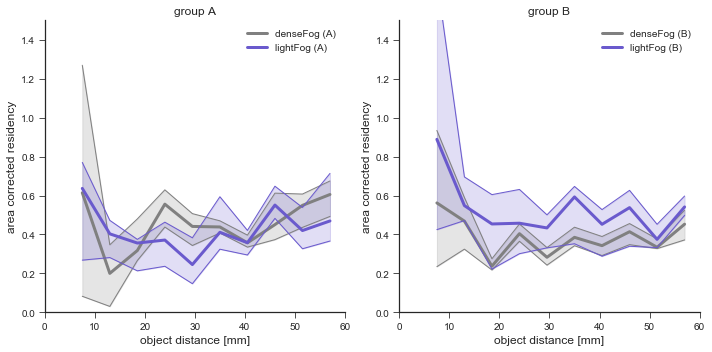

In [51]:
movementFilter = 'moving > 0'
histRange = [5,gridSize]
numBins = 11
varStyle = 'iqr' #'std', 'iqr'

# linear residency
radResFig, axs = plt.subplots(1, len(groupNames), figsize=(10,5))

for g, group in enumerate(groupNames):
    for t, ttype in enumerate(trialtypes):
        
        querystring = '(group =="'+group+'") & (trialtype=="'+ttype+'") & (moving > 0)'
        currCond_df = FOAllFlies_df.query(querystring)
        
        axs[g] = oneDimResidencyWithVar_singleCondition(axs[g], currCond_df, flyIDsStripped, fogcols[ttype], ttype,
                            coneCoords, movementFilter, group, numBins, histRange, 1, False, varStyle, True)
        
    myAxisTheme(axs[g])
    axs[g].set_ylim(0, 1.5)
    axs[g].set_xlim(0,gridSize)
    axs[g].set_title('group '+group)
    axs[g].legend()
    
radResFig.tight_layout()
radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_radialResidencyVar_'+
                  varStyle+'_lin_n'+str(numFlies)+selectionTag+'.pdf', format='pdf')

## Visit-based analysis

In [35]:
def countvisits(dist2Obj,visitRad):
    
    inside = (dist2Obj<visitRad).astype('int')
    time = np.linspace(0,600,len(dist2Obj))

    entries = np.zeros(len(inside))
    entries[1:] = np.diff(inside) == 1

    exits = np.zeros(len(inside))
    exits[1:] = np.diff(inside) == -1
    
    #check if no entries and/or no exits
    if len(inside)==0 or sum(np.diff(inside) == -1)<1:
        visitT = entryTime = exitTime = np.nan
        return entries, exits, visitT, entryTime, exitTime

    entryTime = time[entries.astype('bool')]
    exitTime = time[exits.astype('bool')]
    
    if len(entryTime) == len(exitTime):
        visitT = exitTime - entryTime
    else:
        visitT = exitTime[0:min(sum(exits),sum(entries)).astype('int')] - entryTime[0:min(sum(exits),sum(entries)).astype('int')]
        
    return entries, exits, visitT, entryTime, exitTime

/Users/haberkernh/anaconda/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/haberkernh/anaconda/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice


no cone visits detected
no cone visits detected


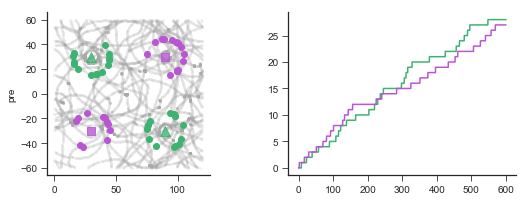

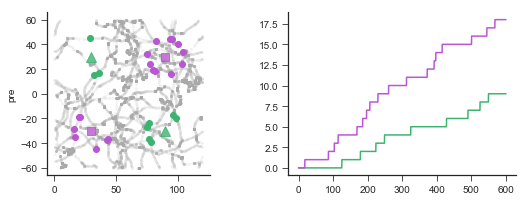

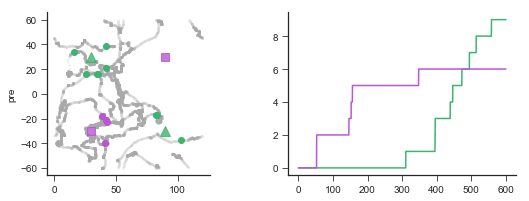

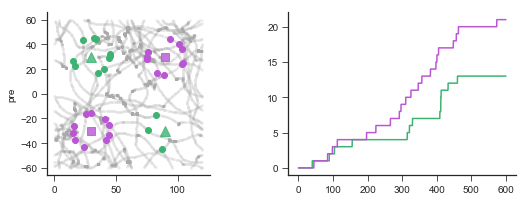

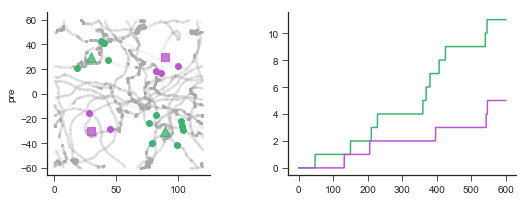

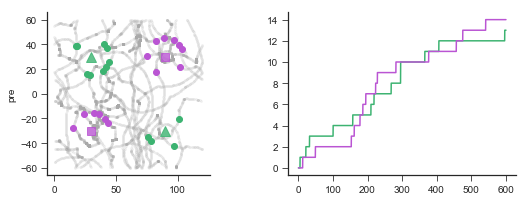

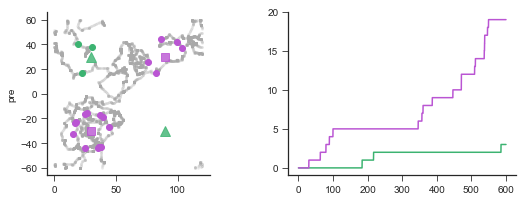

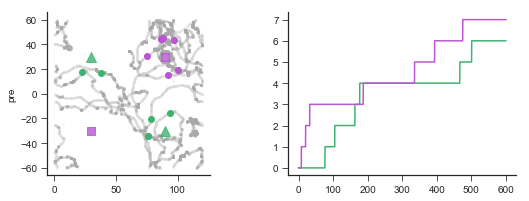

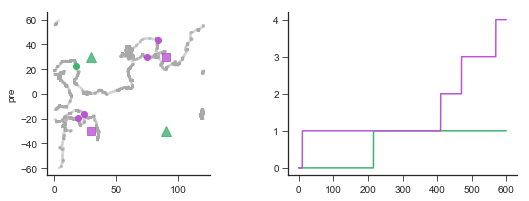

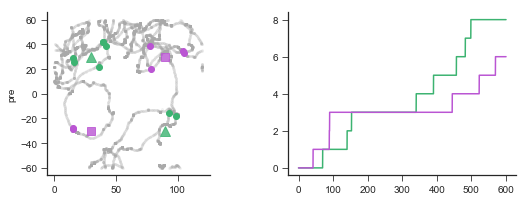

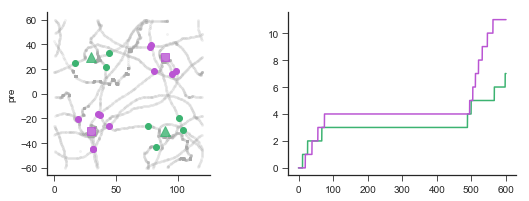

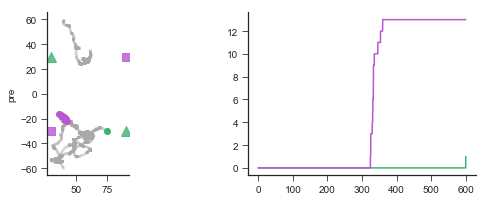

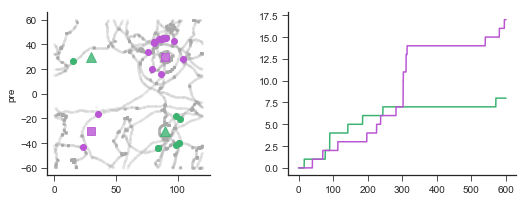

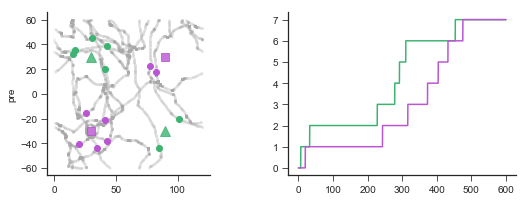

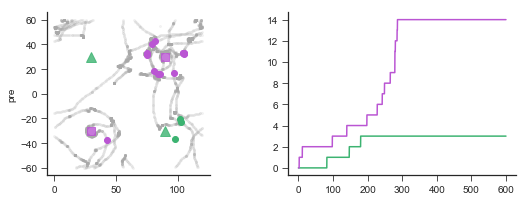

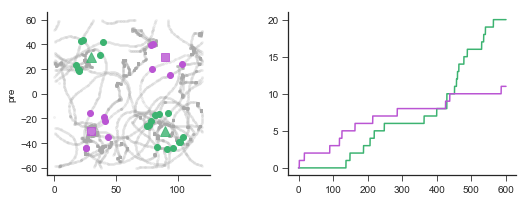

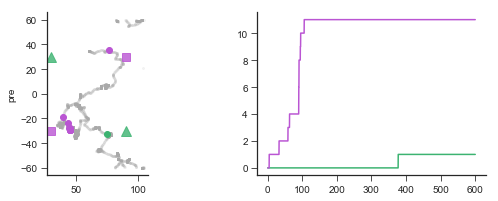

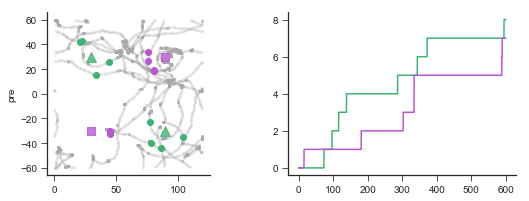

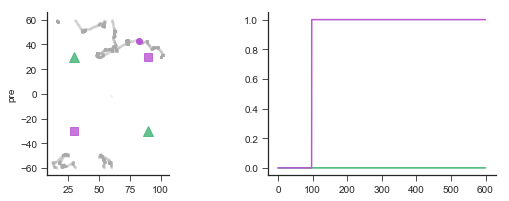

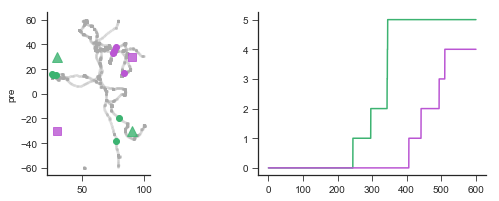

In [36]:
coneVisitFreq = np.zeros((len(flyIDs),len(trialName)))
cyliVisitFreq = np.zeros((len(flyIDs),len(trialName)))

coneVisitCount = np.zeros((len(flyIDs),len(trialName)))
cyliVisitCount = np.zeros((len(flyIDs),len(trialName)))

coneFirstVisit = np.zeros((len(flyIDs),len(trialName)))
cyliFirstVisit = np.zeros((len(flyIDs),len(trialName)))

coneVisitLength = np.zeros((len(flyIDs),len(trialName)))
cyliVisitLength = np.zeros((len(flyIDs),len(trialName)))

coneVisitLengthAV = np.zeros((len(flyIDs),len(trialName)))
cyliVisitLengthAV = np.zeros((len(flyIDs),len(trialName)))


for fly in range(len(flyIDs)):
    visitFig = plt.figure(figsize=(9,3))
    gs = gridspec.GridSpec(len(trialName),2,width_ratios=[1,1])


    for trial in range(len(trialName)):
        trialtype =trialName[trial]

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
        evTrial = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()

        # compute distance to each landmark
        dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)

        entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,visitRad)
        entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,visitRad)

        visitPlt = visitFig.add_subplot(gs[trial,0])
        visitPlt.plot(xPosTrial,yPosTrial,'.',color='darkgrey',markersize=4,alpha=0.1)
        visitPlt.plot(xPosTrial[entriesCone>0],yPosTrial[entriesCone>0],'o',color=coneColor)
        visitPlt.plot(xPosTrial[entriesCyli>0],yPosTrial[entriesCyli>0],'o',color=cyliColor)
        
        for obj in range(2):
            visitPlt.plot(cyliCoords[obj][0], cyliCoords[obj][1], marker='s', markersize=8, alpha=0.8, color=cyliColor)
            visitPlt.plot(coneCoords[obj][0], coneCoords[obj][1], marker='^', markersize=10, alpha=0.8, color=coneColor)

        visitPlt.set_aspect('equal')
        visitPlt.set_ylabel(trialtype)
        myAxisTheme(visitPlt)

        cumsumVisitPlt = visitFig.add_subplot(gs[trial,1])
        cumsumVisitPlt.plot(timeTrial,np.cumsum(entriesCone),color=coneColor)
        cumsumVisitPlt.plot(timeTrial,np.cumsum(entriesCyli),color=cyliColor)
        myAxisTheme(cumsumVisitPlt)
        
        coneVisitFreq[fly,trial] = np.sum(entriesCone)/(timeTrial[-1]/60.0)
        cyliVisitFreq[fly,trial] = np.sum(entriesCyli)/(timeTrial[-1]/60.0)
        
        coneVisitCount[fly,trial] = np.sum(entriesCone)
        cyliVisitCount[fly,trial] = np.sum(entriesCyli)
        
        coneVisitLength[fly,trial] = np.sum(visitTCone)
        cyliVisitLength[fly,trial] = np.sum(visitTCyli)
        
        coneVisitLengthAV[fly,trial] = np.nanmean(visitTCone)
        cyliVisitLengthAV[fly,trial] = np.nanmean(visitTCyli)
        
        try:
            coneFirstVisit[fly,trial] = visitTCone[0]
        except:
            print('no cone visits detected')
            coneFirstVisit[fly,trial] = np.nan
        
        try:
            cyliFirstVisit[fly,trial] = visitTCyli[0]
        except:
            print('no cylinder visits detected')
            cyliFirstVisit[fly,trial] = np.nan


    try:
        mkdir(analysisDir + 'reinforcementEffect/')
    except:
        pass
    visitFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                       +'_effectOnVisits_visitRad'+str(visitRad)+'mm_fly'+ flyIDs[fly] +'.pdf', format='pdf')

### Helper functions for plotting

In [42]:
def simpleBoxPlot(bpPlt, myBoxCols, myObjVals, flyIDs, offsets, plotLabels):
    # myObjVals should be e.g. VisitCount[objtype], myBoxCols should be objBoxColors[objtype]
    
    boxs = bpPlt.boxplot(myObjVals,patch_artist=True)
    plt.setp(boxs['whiskers'], color='black',linestyle='-')
    plt.setp(boxs['medians'], color='black',linewidth=2)
    plt.setp(boxs['fliers'], color='grey', marker='+')
    
    jitter = np.random.normal(0, 0.025, size=len(myObjVals))
    
    for ind,box in enumerate(boxs['boxes']):
        plt.setp(box,color=myBoxCols,linewidth=1.5,alpha=boxalpha)
        boxprops = dict(linestyle='-', linewidth=1.5, color='grey')

        # Add some random "jitter" to the x-axis
        x = ind+jitter+offsets[ind]
        bpPlt.plot(x, myObjVals, 'o', color=myBoxCols, alpha=0.8)
    
    for fly in range(len(flyIDs)):
        bpPlt.plot(0, myObjVals[fly], '-', color='grey', linewidth = 0.5, alpha=linealpha)
        
        if plotLabels:
            bpPlt.text(1-.91+jitter[fly]+offsets[-1], myObjVals[fly],flyIDs[fly])
    
    plt.sca(bpPlt)
    plt.xticks([1.1],trialName)
    bpPlt.axhline(y=0, linewidth=1,color='grey', linestyle='dashed')
    bpPlt.set_xlim((0.75,1.5))
    myAxisTheme(bpPlt)
    
    return bpPlt

In [43]:
def prettyBoxPlot(bpPlt, myBoxCols, myObjVals, flyIDs, offsets, plotLabels):
    # myObjVals should be e.g. VisitCount[objtype], myBoxCols should be objBoxColors[objtype]
    
    myBoxVals = [myObjVals[~np.isnan(myObjVals[:,0]),0],myObjVals[~np.isnan(myObjVals[:,1]),1]]
    boxs = bpPlt.boxplot(myBoxVals,patch_artist=True)
    plt.setp(boxs['whiskers'], color='black',linestyle='-')
    plt.setp(boxs['medians'], color='black',linewidth=2)
    plt.setp(boxs['fliers'], color='grey', marker='+')
    
    jitter = np.random.normal(0, 0.012*len(offsets), size=len(myObjVals[:,0]))
             
    for ind,box in enumerate(boxs['boxes']):
        plt.setp(box,color=myBoxCols[ind],linewidth=1.5,alpha=boxalpha)
        boxprops = dict(linestyle='-', linewidth=1.5, color='grey')

        # Add some random "jitter" to the x-axis
        x = ind+jitter+offsets[ind]
        bpPlt.plot(x, myObjVals[:,ind], 'o', color=myBoxCols[ind], alpha=0.8)
    
    for fly in range(len(flyIDs)):
        trialOffSets = np.vstack((0+jitter[fly]+offsets[0],1+jitter[fly]+offsets[1]))
        bpPlt.plot(trialOffSets, myObjVals[fly,:], '-', color='grey', linewidth = 0.5, alpha=linealpha)
        
        if plotLabels:
            bpPlt.text(len(offsets)-.91+jitter[fly]+offsets[-1], myObjVals[fly,-1],flyIDs[fly])
   
    plt.sca(bpPlt)
    plt.xticks(range(1,3), objtypeNames)
    bpPlt.axhline(y=0, linewidth=1,color='grey', linestyle='dashed')
    bpPlt.set_ylim((-0.1*np.nanmax(myObjVals),(0.1*np.nanmax(myObjVals))+np.nanmax(myObjVals)))
    myAxisTheme(bpPlt)
        
    return bpPlt

### Shared settings for plots

In [44]:
# Settings for boxplots of all three trials:

objtypeNames = ['Cone','Cylinder']

objBoxColors = [coneColor,cyliColor] #for spec. objects
BoxColors = 'grey' # for ratio between objects

trialColors = ['darkseagreen']
trialMarkers = ['d']

offsets = [1.2]

boxalpha = 0.5
linealpha=0.5

offsets_pp = [1.32, 0.68]

### Comparison of visits to the two landmarks

Plot directory already exists


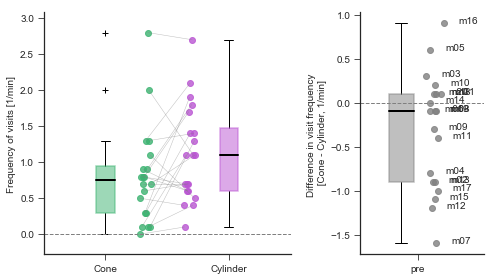

In [47]:
bpFig, axs = plt.subplots(1,2,figsize=(7,4),gridspec_kw=dict(width_ratios=[2,1]))

VisitFreq = np.hstack((coneVisitFreq,cyliVisitFreq))

objBoxPlt = prettyBoxPlot(axs[0], objBoxColors, VisitFreq, flyIDs, offsets_pp, plotLabels=False)

axs[0].set_ylabel('Frequency of visits [1/min]')

VisitCountRatio = np.squeeze(coneVisitFreq)-np.squeeze(cyliVisitFreq)

ratioBoxPlt = simpleBoxPlot(axs[1], BoxColors, VisitCountRatio, flyIDs, offsets, plotLabels=True)

axs[1].set_ylabel('Difference in visit frequency \n [Cone - Cylinder, 1/min]')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                   +'_visitFreqAndPref_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

In [48]:
from scipy import stats as sts
tval, pval = sts.ttest_rel(coneVisitFreq, cyliVisitFreq, axis=0, nan_policy='propagate')
#bpPlt.set_title('Cone visits ~ Cylinder visits, p = ' + str(round(pval,4)))
print('p = ' + str(pval))

p = [ 0.04779486]


In [49]:
tval, pval = sts.ttest_1samp(VisitCountRatio, popmean=0)
#bpPlt.set_title('Cone visits ~ Cylinder visits, p = ' + str(round(pval,4)))
print('p = ' + str(pval))

p = 0.0477948642471


Plot directory already exists


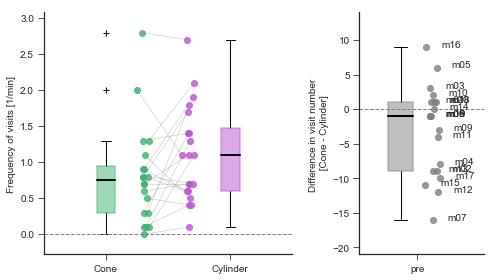

In [50]:
bpFig, axs = plt.subplots(1,2,figsize=(7,4),gridspec_kw=dict(width_ratios=[2,1]))

VisitFreq = np.hstack((coneVisitFreq,cyliVisitFreq))

objBoxPlt = prettyBoxPlot(axs[0], objBoxColors, VisitFreq, flyIDs, offsets_pp, plotLabels=False)

axs[0].set_ylabel('Frequency of visits [1/min]')

VisitCountRatio = np.squeeze(coneVisitCount)-np.squeeze(cyliVisitCount)

ratioBoxPlt = simpleBoxPlot(axs[1], BoxColors, VisitCountRatio, flyIDs, offsets, plotLabels=True)

axs[1].set_ylim((-5+np.min(VisitCountRatio),5+np.max(VisitCountRatio)))
axs[1].set_ylabel('Difference in visit number \n [Cone - Cylinder]')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                   +'_visitFreqAndPref_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

Plot directory already exists


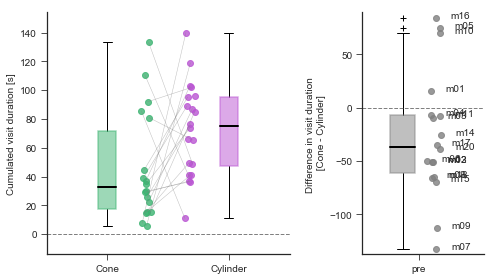

In [51]:
bpFig, axs = plt.subplots(1,2,figsize=(7,4),gridspec_kw=dict(width_ratios=[2,1]))

VisitLength = np.hstack((coneVisitLength,cyliVisitLength))

objBoxPlt = prettyBoxPlot(axs[0], objBoxColors, VisitLength, flyIDs, offsets_pp, plotLabels=False)

axs[0].set_ylabel('Cumulated visit duration [s]')

VisitLengthRatio = np.squeeze(coneVisitLength)-np.squeeze(cyliVisitLength)
slct = np.where(~np.isnan(VisitLengthRatio))[0]
from operator import itemgetter

ratioBoxPlt = simpleBoxPlot(axs[1], BoxColors, VisitLengthRatio[slct], 
                            [flyIDs[i] for i in slct], offsets, plotLabels=True)

axs[1].set_ylim((-5+np.nanmin(VisitLengthRatio),5+np.nanmax(VisitLengthRatio)))
axs[1].set_ylabel('Difference in visit duration \n [Cone - Cylinder]')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                   +'_visitLengthAndPref_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

In [52]:
# Compute average per fly velocities

vTrans = np.zeros((len(flyIDs)))
vRot = np.zeros((len(flyIDs)))
pcMov = np.zeros((len(flyIDs)))

for fly in range(len(flyIDs)):
    querystring = '(flyID == "'+flyIDs[fly]+'")'
    timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
    perFlyvT = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].values.squeeze()
    perFlyvR = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].values.squeeze()
    perFlymov = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].values.squeeze()

    tSt = 0
    tEnd = len(timeTrial)
    vt = perFlyvT[tSt:tEnd]
    vr = perFlyvR[tSt:tEnd]
    mov = perFlymov.astype('bool')[tSt:tEnd] 
    vTrans[fly] = np.squeeze(np.nanmedian(vt[mov]))
    vRot[fly] = np.squeeze(np.nanmedian(abs(vr[mov])))
    pcMov[fly] = 100*sum(mov)/len(mov)

Plot directory already exists


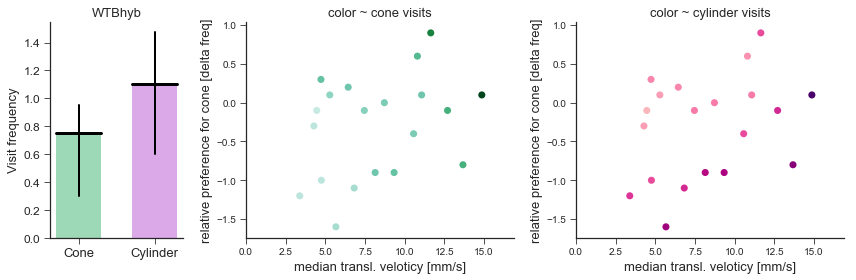

In [53]:
visitCountFig, axs = plt.subplots(1,3,figsize=(12,4), gridspec_kw = dict(width_ratios = [1,2,2]))

# Bar plot with error bars
ind = np.arange(2)
width = 0.6

relPref = np.squeeze(coneVisitFreq)-np.squeeze(cyliVisitFreq)


avCounts = (np.median(np.squeeze(coneVisitFreq)),np.median(np.squeeze(cyliVisitFreq)))
iqr = [np.percentile(np.squeeze(coneVisitFreq), [25,75]),np.percentile(np.squeeze(cyliVisitFreq), [25,75])]

p1 = axs[0].bar(ind, avCounts, width, color=[coneColor,cyliColor], alpha=boxalpha)
for obj in range(len(ind)):
    axs[0].plot([ind[obj],ind[obj]],[iqr[obj][0],iqr[obj][1]] ,color='k',linewidth=2)
    axs[0].plot([ind[obj]-width/2,ind[obj]+width/2],[avCounts[obj],avCounts[obj]] ,color='k',linewidth=3)

axs[0].set_ylabel('Visit frequency', fontsize=13)
axs[0].set_title(genotype, fontsize=13)

plt.sca(axs[0])
plt.xticks(ind, LMnames, fontsize=13)
plt.yticks(fontsize=12);
myAxisTheme(axs[0])


# Relation of visit count to walking velocity
axs[1].scatter(vTrans,relPref,s=50,c=coneVisitFreq,cmap='BuGn',vmin=-1,edgecolor='none')
axs[2].scatter(vTrans,relPref,s=50,c=cyliVisitFreq,cmap='RdPu',vmin=-1,edgecolor='none')

axs[1].set_title('color ~ cone visits',fontsize=13)
axs[2].set_title('color ~ cylinder visits',fontsize=13)

for ax in axs[1:]:
    ax.set_xlim(0, (max(vTrans)+2))
    ax.set_xlabel('median transl. veloticy [mm/s]',fontsize=13)
    ax.set_ylabel('relative preference for cone [delta freq]',fontsize=13)
    myAxisTheme(ax)
visitCountFig.tight_layout()


try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
visitCountFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                   +'_visitFreqAndVelo_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

Plot directory already exists


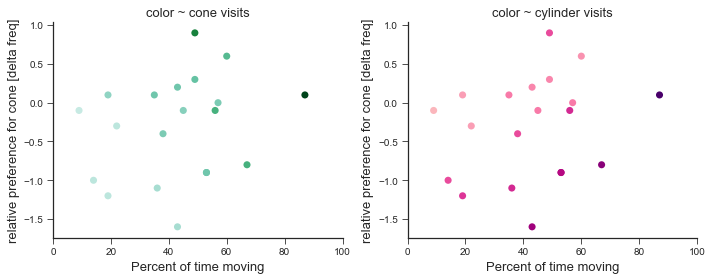

In [54]:
visitCountFig, axs = plt.subplots(1,2,figsize=(10,4), gridspec_kw = dict(width_ratios = [2,2]))

relPref = np.squeeze(coneVisitFreq)-np.squeeze(cyliVisitFreq)

# Relation of visit count to walking velocity
axs[0].scatter(pcMov,relPref,s=50,c=coneVisitFreq,cmap='BuGn',vmin=-1,edgecolor='none')
axs[1].scatter(pcMov,relPref,s=50,c=cyliVisitFreq,cmap='RdPu',vmin=-1,edgecolor='none')

axs[0].set_title('color ~ cone visits',fontsize=13)
axs[1].set_title('color ~ cylinder visits',fontsize=13)

for ax in axs:
    ax.set_xlim(0, 100)
    ax.set_xlabel('Percent of time moving',fontsize=13)
    ax.set_ylabel('relative preference for cone [delta freq]',fontsize=13)
    myAxisTheme(ax)
visitCountFig.tight_layout()


try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
visitCountFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                   +'_visitFreqAndMov_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### TODO: Visit count demo

/Users/haberkernh/anaconda/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


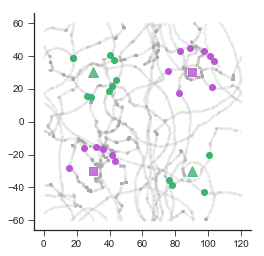

In [445]:
fly = 5

visitFig = plt.figure()
visitPlt = visitFig.add_subplot(1,1,1)

querystring = '(flyID == "'+flyIDs[fly]+'")'
xPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
yPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
evTrial = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()

# compute distance to each landmark
dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

# compute distance to closest landmark
dist2closestCone = np.minimum(dist2cone1,dist2cone2)
dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)

entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,visitRad)
entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,visitRad)

visitPlt.plot(xPosTrial,yPosTrial,'.',color='darkgrey',markersize=4,alpha=0.1)
visitPlt.plot(xPosTrial[entriesCone>0],yPosTrial[entriesCone>0],'o',color=coneColor)
visitPlt.plot(xPosTrial[entriesCyli>0],yPosTrial[entriesCyli>0],'o',color=cyliColor)

for obj in range(2):
    visitPlt.plot(cyliCoords[obj][0], cyliCoords[obj][1], marker='s', markersize=8, alpha=0.8, color=cyliColor)
    visitPlt.plot(coneCoords[obj][0], coneCoords[obj][1], marker='^', markersize=10, alpha=0.8, color=coneColor)

visitPlt.set_aspect('equal')
myAxisTheme(visitPlt)